<a href="https://colab.research.google.com/github/derek-pyne/ml_playground/blob/master/Final_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN with generated data
Author: Derek Pyne

Our goal is to explore conditional GANS to allow us to produce labelled data.

Generated data is used to allow us to use a simpler model. This decreases training time and is less sensitive to hyperparameters giving us an easier environment to test out CGANs. 

Please check out the attached presentation to see the full story that led to using generated data.

The work will follow two phases:

1.   Train Traditional GAN to see if model shows initial ability to model dataset
2.   Train Conditioned GAN to produce labelled images

In [1]:
import datetime
import random
import time
from google.colab import drive
from pathlib import Path
import zipfile

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Concatenate, \
    Input, Dense, Reshape, Flatten, Dropout, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


In [0]:
IMAGE_SIZE = 28
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_CLASSES = 3
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 250
EPOCHS = 500
BETA1 = 0.5
EPSILON = 0.00005
WEIGHT_INIT_STDDEV = 0.02
SAMPLES_TO_SHOW = 5
NOISE_PROP = .05

## 1) Building dataset
A simple dataset is built with three classes: 

*   Pink triangles
*   Yellow squares
*   Purple circles

All images share a common background color, but have varied size and locations.

Small 28x28 images are used to speed up training time.


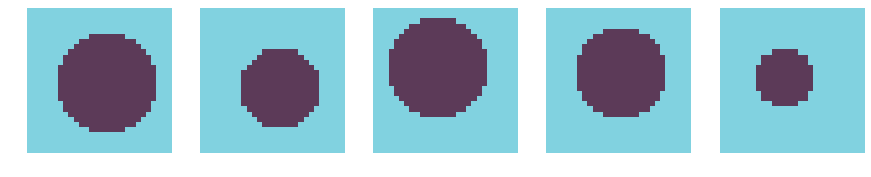

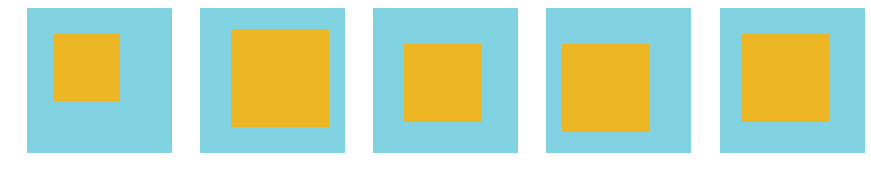

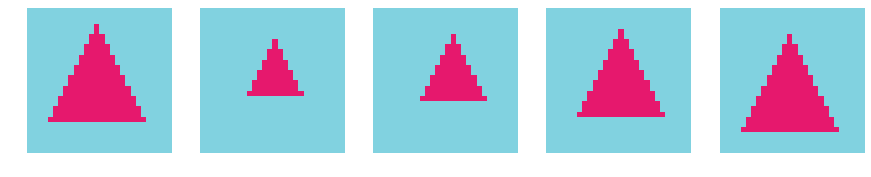

In [3]:
def create_blank_image(color=(129,210,224)):
    image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color)
    return image

def draw_circle(image=None, color=(92,58,88)):
    if not image:
        image = create_blank_image()
    width = image.width
    r = width//5 + np.random.randint(0, width//5)
    x = width//2 + np.random.randint(-width//10, width//10)
    y = width//2 + np.random.randint(-width//10, width//10)
    draw = ImageDraw.Draw(image)
    draw.ellipse((x-r, y-r, x+r, y+r), fill=color)
    return np.array(image)

def draw_square(image=None, color=(237,182,37)):
    if not image:
        image = create_blank_image()
    width = image.width
    h = width//5 + np.random.randint(0, width//5)
    x = width//2 + np.random.randint(-width//10, width//10)
    y = width//2 + np.random.randint(-width//10, width//10)
    draw = ImageDraw.Draw(image)
    draw.rectangle((x-h, y-h, x+h, y+h), fill=color)
    return np.array(image)

def draw_triangle(image=None, color=(230,24,109)):
    if not image:
        image = create_blank_image()
    width = image.width
    h = width//5 + np.random.randint(0, width//5)
    x = width//2 + np.random.randint(-width//10, width//10)
    y = width//2 + np.random.randint(-width//10, width//10)
    points = [
        (x-h, y+h),
        (x, y-h),
        (x+h, y+h)
    ]
    draw = ImageDraw.Draw(image)
    draw.polygon(points, fill=color)
    return np.array(image)
    
def show_samples(sample_images, labels=None, label_map=None):
    figure, axes = plt.subplots(1, len(sample_images), 
                                figsize=(3*len(sample_images), 3*len(sample_images)), 
                                squeeze=False)
    
    for index, axis in enumerate(axes[0, :]):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        if labels is not None:
            label_string = labels[index]
            if label_map is not None: 
                label_string = label_map[label_string]
            axis.set_title(label_string)
    plt.show()

show_samples([draw_circle() for _ in range(SAMPLES_TO_SHOW)])
show_samples([draw_square() for _ in range(SAMPLES_TO_SHOW)])
show_samples([draw_triangle() for _ in range(SAMPLES_TO_SHOW)])

In [0]:
images = []
labels = []
label_map = {
    'circle': 0,
    'square': 1,
    'triangle': 2
}

label_idx_map = {v: k for k, v in label_map.items()}
for _ in range(500):
    images.append(draw_circle())
    labels.append(label_map['circle'])
    images.append(draw_square())
    labels.append(label_map['square'])
    images.append(draw_triangle())
    labels.append(label_map['triangle'])
    
images = np.asarray(images)
labels = np.asarray(labels)

p = np.random.permutation(len(images))
images = images[p]
labels = labels[p]

## 2) Building Traditional GAN

Since our dataset is relatively simple, we can use a standard deep convolutional model. We will base our model on the hyperparameters in Assignment 4 and some of the architectures [here](https://github.com/eriklindernoren/Keras-GAN).

In [0]:
def create_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=NOISE_SIZE))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    return model

def create_discriminator():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(NOISE_SIZE,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan


def describe_keras_model(model, name):
    print('-' * 20)
    print(name)
    print('-' * 20)
    print()
    print('Input Shape: {}'.format(model.inputs))
    print('Output Shape: {}'.format(model.outputs))
    print()
    model.summary()
    print()

In [6]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_D, beta_1=BETA1), metrics=['accuracy'])
gan = create_gan(discriminator, generator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_G, beta_1=BETA1), metrics=['accuracy'])

describe_keras_model(generator, 'GENERATOR')
describe_keras_model(discriminator, 'DISCRIMINATOR')
describe_keras_model(gan, 'GAN')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
--------------------
GENERATOR
--------------------

Input Shape: [<tf.Tensor 'dense_1_input:0' shape=(?, 100) dtype=float32>]
Output Shape: [<tf.Tensor 'activation_3/Tanh:0' shape=(?, 28, 28, 3) dtype=float32>]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
______

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## 3) Training Traditional GAN

We train our model in two steps:

1.   Train discriminator to differentiate generated from real images
2.   Train our generator to trick the discriminator into thinking a real image was produced

We need to make sure that the generator and discriminator improve at roughly the same pace, otherwise there will be no feedback for the underperforming model.

Usually, the discriminator outperforms the generator so we will add some noise to slow it down a little. 

*   Use noisy labels for real/fake data
*   Flip a small percent of labels fed to discriminator



In [0]:
def test(generator):
    noise = np.random.uniform(-1, 1, size=(SAMPLES_TO_SHOW, NOISE_SIZE))
    samples = generator.predict(noise)
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images)
    
def summarize_epoch(test_func, epoch, duration, generator, d_losses, g_losses, g_accuracy):
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-BATCH_SIZE:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-BATCH_SIZE:])))
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    axs[0].plot(d_losses, label='Discriminator', alpha=0.6)
    axs[0].plot(g_losses, label='Generator', alpha=0.6)
    axs[0].set_title("Losses")
    axs[0].legend()
    axs[1].plot(g_accuracy, label='g_accuracy', alpha=0.6)
    axs[1].set_title("Accuracy")
    axs[1].legend()
    plt.show()
    test_func(generator)
    
def get_batches(data, labels=None):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    
    if labels is not None:
        label_batches = []
        for i in range(int(data.shape[0]//BATCH_SIZE)):
            label_batch = labels[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            label_batches.append(label_batch)
        return batches, label_batches
    else :
        return batches

def train(get_batches, generator, discriminator, gan):
    d_losses = []
    g_losses = []
    g_accuracy = []
    for epoch in range(EPOCHS):
        epoch += 1
        start_time = time.time()

        for batch_images in get_batches:
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
            generated_images = generator.predict(noise)

            valid_soft = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
            flipped_idx = np.random.choice(np.arange(len(valid_soft)), size=int(NOISE_PROP*len(valid_soft)))
            valid_soft[flipped_idx] = 1 - valid_soft[flipped_idx]

            fake_soft = np.random.uniform(0.0, 0.1, size=(BATCH_SIZE, 1))

            d_loss_real, _ = discriminator.train_on_batch(batch_images, valid_soft)
            d_loss_fake, _ = discriminator.train_on_batch(generated_images, fake_soft)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_losses.append(d_loss)

            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))                                                 
            valid = np.ones((BATCH_SIZE, 1))
            g_loss, gan_acc = gan.train_on_batch(noise, valid)
            g_accuracy.append(gan_acc)
            g_losses.append(g_loss)

        if epoch % 50 == 0:
            summarize_epoch(test, epoch, time.time()-start_time, generator, d_losses, g_losses, g_accuracy)


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 50/500 
Duration: 1.09455 
D Loss: 0.77938 
G Loss: 0.88394


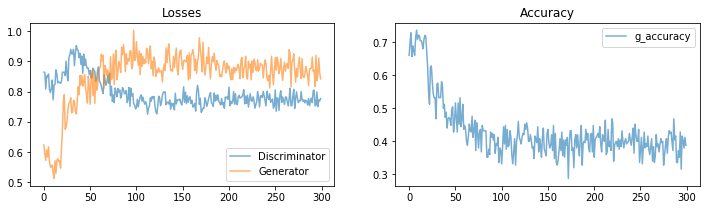

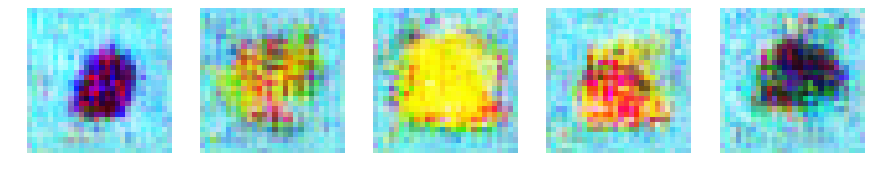

Epoch 100/500 
Duration: 1.10255 
D Loss: 0.77009 
G Loss: 0.84091


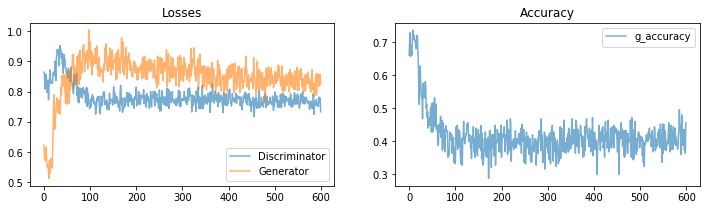

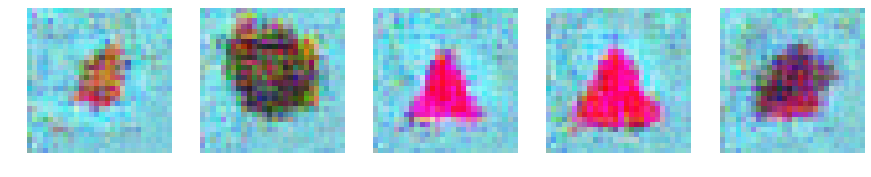

Epoch 150/500 
Duration: 1.09636 
D Loss: 0.75837 
G Loss: 0.83300


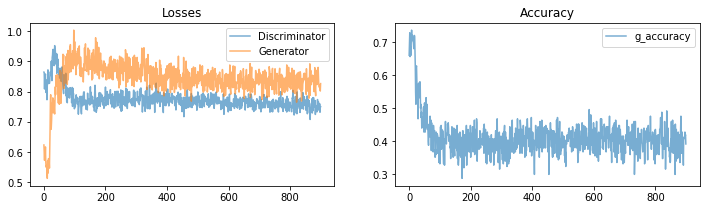

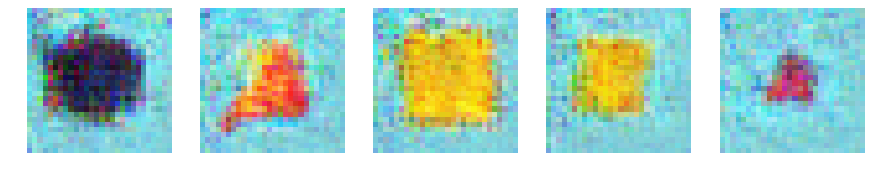

Epoch 200/500 
Duration: 1.10217 
D Loss: 0.75073 
G Loss: 0.83197


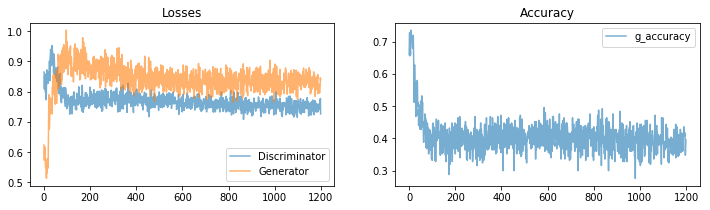

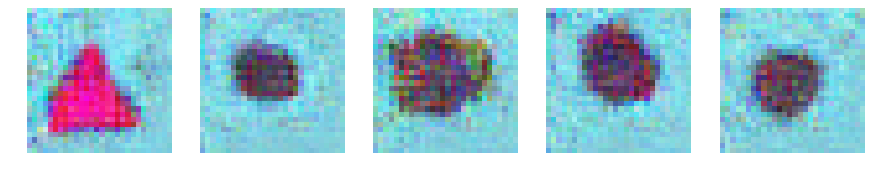

Epoch 250/500 
Duration: 1.09741 
D Loss: 0.74340 
G Loss: 0.83366


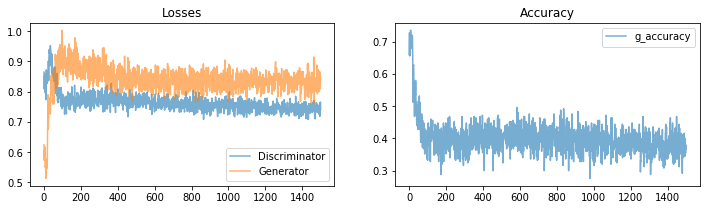

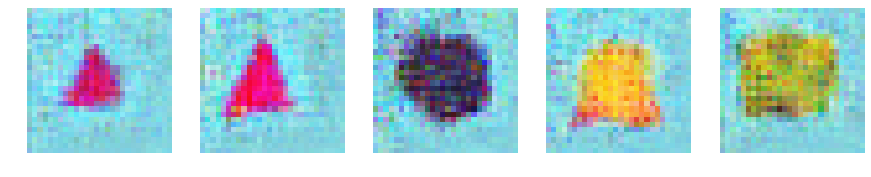

Epoch 300/500 
Duration: 1.10794 
D Loss: 0.73533 
G Loss: 0.83517


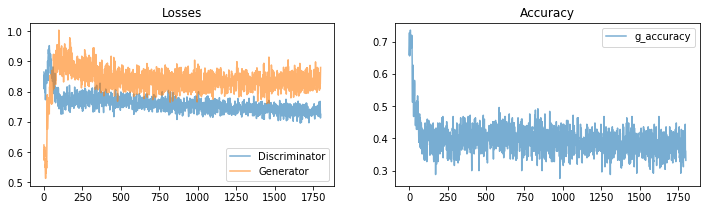

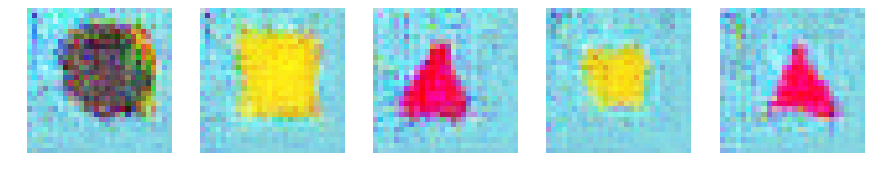

Epoch 350/500 
Duration: 1.09798 
D Loss: 0.72715 
G Loss: 0.84170


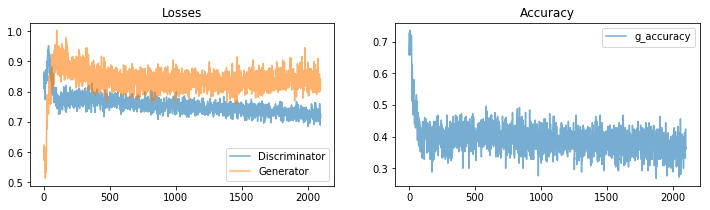

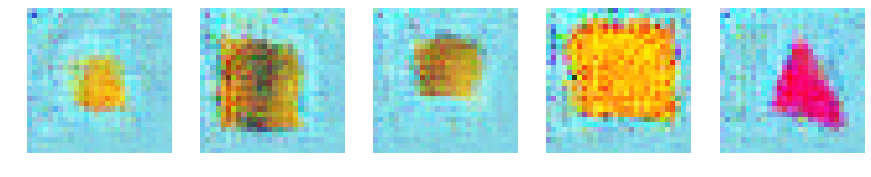

Epoch 400/500 
Duration: 1.09971 
D Loss: 0.72381 
G Loss: 0.84496


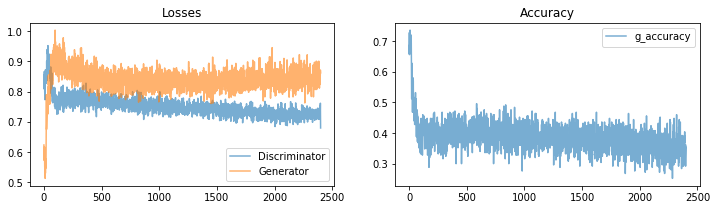

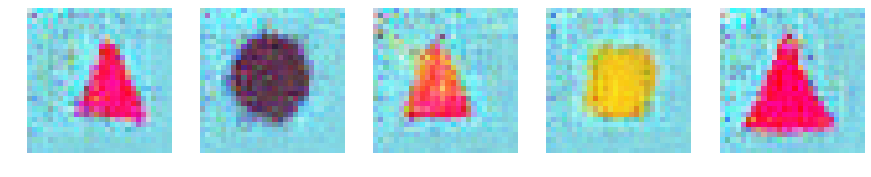

Epoch 450/500 
Duration: 1.10209 
D Loss: 0.72077 
G Loss: 0.84887


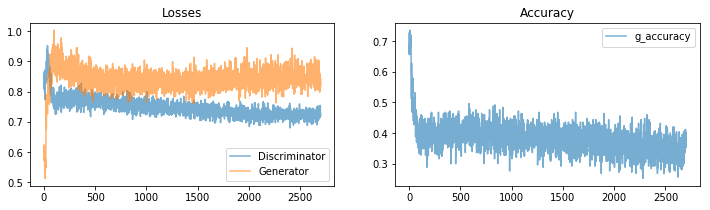

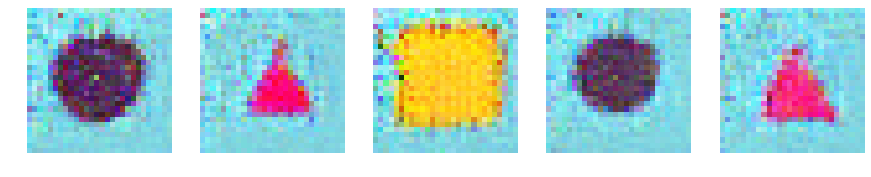

Epoch 500/500 
Duration: 1.09431 
D Loss: 0.71986 
G Loss: 0.85150


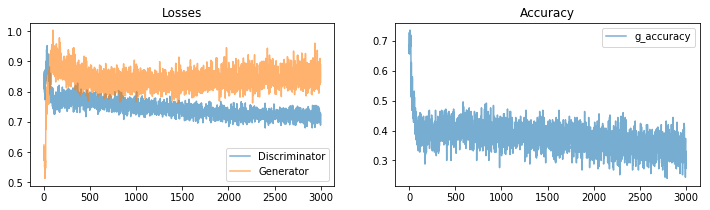

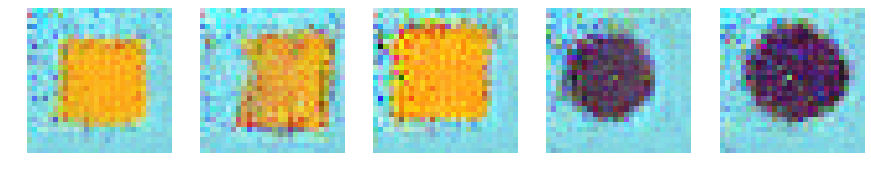

In [8]:
train(get_batches(images), generator, discriminator, gan)

## 4) Adding in labels
Since our Traditional GAN showed strong promise. We'll move forward with a Conditional GAN.

We already have our labels produced and can remind ourselves what the labelled images look like.

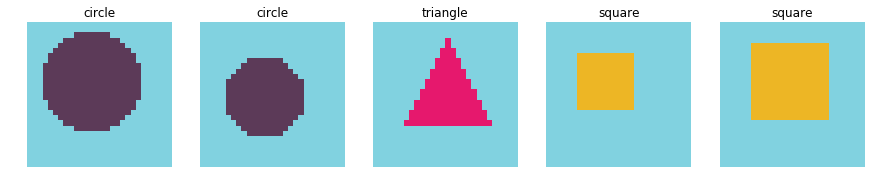

In [9]:
sample_idx = np.random.choice(len(images), SAMPLES_TO_SHOW)
show_samples(images[sample_idx], labels[sample_idx], label_idx_map)

## 5) Building Conditional GAN
In our Conditional GAN we additionally pass the one-hot-encoded class labels to both our generator and discriminator along with their previous input (noise vector and images respectively).

With Keras, multiple inputs are not supported with the `Sequential API` so we will use the `Functional API`.

We will use the same convulutional layers as before with an added dense layer in our discriminator to handle the label vectors.

In [10]:
def create_generator_labels(input_layer, condition_layer):
    
    merged_input = Concatenate()([input_layer, condition_layer])  

    hid = Dense(128 * 7 * 7, activation="relu", input_dim=NOISE_SIZE)(merged_input)
    hid = Reshape((7, 7, 128))(hid)
    hid = UpSampling2D()(hid)
    hid = Conv2D(128, kernel_size=3, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = Activation("relu")(hid)
    hid = UpSampling2D()(hid)
    hid = Conv2D(64, kernel_size=3, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = Activation("relu")(hid)
    hid = Conv2D(3, kernel_size=3, padding="same")(hid)
    out = Activation("tanh")(hid)
    
    model = Model(inputs=[input_layer, condition_layer], outputs=out)
    
    return model, out

def create_discriminator_labels(input_layer, condition_layer):

    hid = Conv2D(32, kernel_size=3, strides=2, input_shape=IMAGE_SHAPE, padding="same")(input_layer)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Dropout(0.25)(hid)
    hid = Conv2D(64, kernel_size=3, strides=2, padding="same")(hid)
    hid = ZeroPadding2D(padding=((0,1),(0,1)))(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Dropout(0.25)(hid)
    hid = Conv2D(128, kernel_size=3, strides=2, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Dropout(0.25)(hid)
    hid = Conv2D(256, kernel_size=3, strides=1, padding="same")(hid)
    hid = BatchNormalization(momentum=0.8)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Dropout(0.25)(hid)
    hid = Flatten()(hid)
    
    merged_layer = Concatenate()([hid, condition_layer])
    hid = Dense(512, activation='relu')(merged_layer)
    out = Dense(1, activation='sigmoid')(hid)
    model = Model(inputs=[input_layer, condition_layer], outputs=out)
    return model, out

img_input = Input(shape=IMAGE_SHAPE)
disc_condition_input = Input(shape=(NUM_CLASSES,))

discriminator_labels, disc_out = create_discriminator_labels(img_input, disc_condition_input)
discriminator_labels.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_D, beta_1=BETA1), metrics=['accuracy'])

discriminator_labels.trainable = False

noise_input = Input(shape=(NOISE_SIZE,))
gen_condition_input = Input(shape=(NUM_CLASSES,))
generator_labels, gen_out = create_generator_labels(noise_input, gen_condition_input)

gan_input = Input(shape=(NOISE_SIZE,))
x = generator_labels([gan_input, gen_condition_input])
gan_out = discriminator_labels([x, disc_condition_input])
gan_labels = Model(inputs=[gan_input, gen_condition_input, disc_condition_input], output=gan_out)


gan_labels.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_G, beta_1=BETA1), metrics=['accuracy'])


describe_keras_model(generator_labels, 'GENERATOR')
describe_keras_model(discriminator_labels, 'DISCRIMINATOR')
describe_keras_model(gan_labels, 'GAN')

--------------------
GENERATOR
--------------------

Input Shape: [<tf.Tensor 'input_4:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 3) dtype=float32>]
Output Shape: [<tf.Tensor 'activation_6/Tanh:0' shape=(?, 28, 28, 3) dtype=float32>]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 103)          0           input_4[0][0]                    
                                                

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## 6) Training Conditional GAN
Training is done in exactly the same way as before except with our label vectors added as inputs.

In [0]:
def generate_random_labels(n):
    y = np.random.choice(NUM_CLASSES, n)
    y_encode = to_categorical(y, num_classes=NUM_CLASSES)
    return y_encode, y

def test_with_labels(generator):
    noise = np.random.uniform(-1, 1, size=(SAMPLES_TO_SHOW, NOISE_SIZE))
    sample_labels_encode, sample_labels = generate_random_labels(SAMPLES_TO_SHOW)
    samples = generator.predict([noise, sample_labels_encode])
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, [label_idx_map[k] for k in sample_labels])

def train_with_labels(get_batches, generator, discriminator, gan):
    d_losses = []
    g_losses = []
    d_real_accuracy = []
    d_fake_accuracy = []
    g_accuracy = []
    for epoch in range(EPOCHS):
        epoch += 1
        start_time = time.time()

        for batch_images, batch_labels in zip(*get_batches):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
            random_labels, _ = generate_random_labels(BATCH_SIZE)
            
            generated_images = generator.predict([noise, random_labels])

            valid_soft = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
            flipped_idx = np.random.choice(np.arange(len(valid_soft)), size=int(NOISE_PROP*len(valid_soft)))
            valid_soft[flipped_idx] = 1 - valid_soft[flipped_idx]

            fake_soft = np.random.uniform(0.0, 0.1, size=(BATCH_SIZE, 1))

            noisy_batch_images = batch_images
            d_loss_real, d_real_acc = discriminator.train_on_batch([noisy_batch_images, batch_labels], valid_soft)
            d_loss_fake, d_fake_acc = discriminator.train_on_batch([generated_images, random_labels], fake_soft)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_losses.append(d_loss)
            d_real_accuracy.append(d_real_acc)
            d_fake_accuracy.append(d_fake_acc)

            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
            random_labels, _ = generate_random_labels(BATCH_SIZE)
            valid = np.ones((BATCH_SIZE, 1))
            g_loss, gan_acc = gan.train_on_batch([noise, random_labels, random_labels], valid)
            g_accuracy.append(gan_acc)
            g_losses.append(g_loss)

        if epoch % 50 == 0:
            summarize_epoch(test_with_labels, epoch, time.time()-start_time, generator, d_losses, g_losses, g_accuracy)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 50/500 
Duration: 1.19107 
D Loss: 0.71265 
G Loss: 0.95665


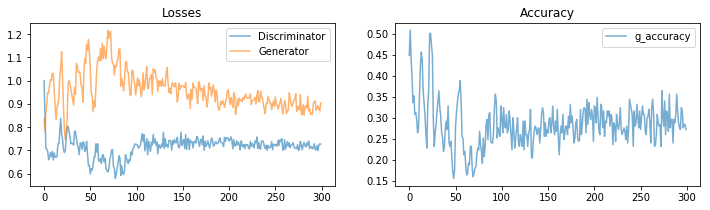

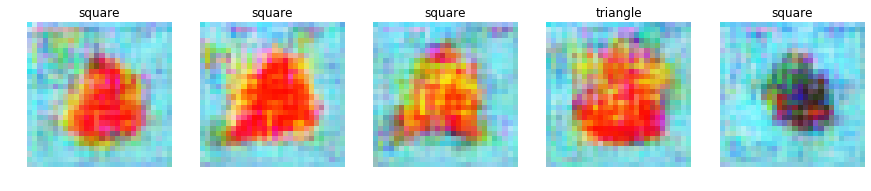

Epoch 100/500 
Duration: 1.20420 
D Loss: 0.70167 
G Loss: 0.86721


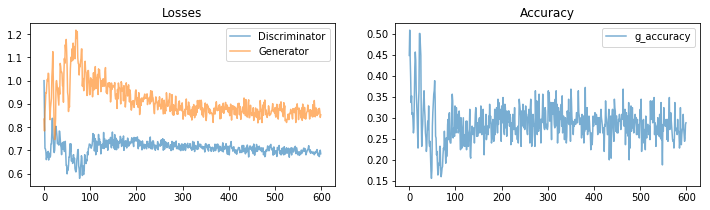

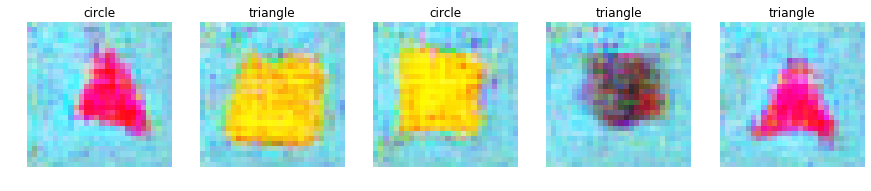

Epoch 150/500 
Duration: 1.20276 
D Loss: 0.68757 
G Loss: 0.85927


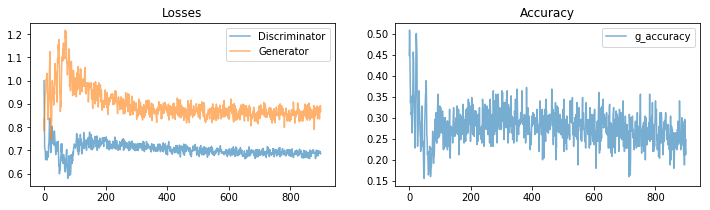

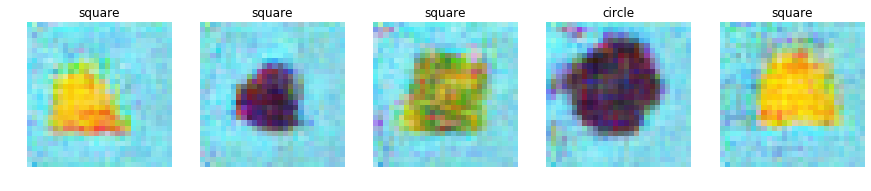

Epoch 200/500 
Duration: 1.20276 
D Loss: 0.67468 
G Loss: 0.87560


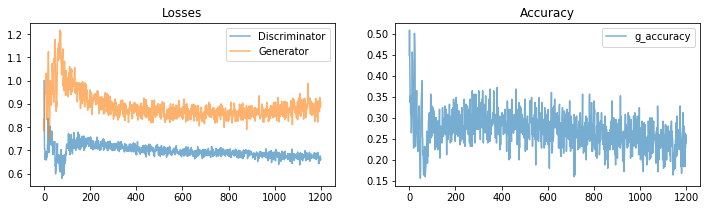

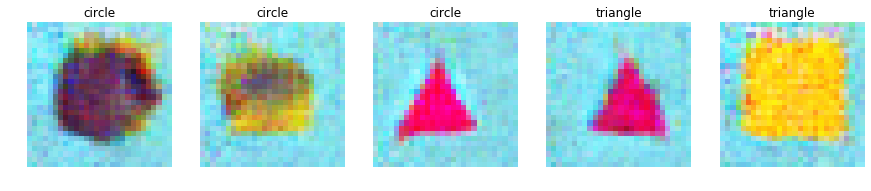

Epoch 250/500 
Duration: 1.20021 
D Loss: 0.66095 
G Loss: 0.93280


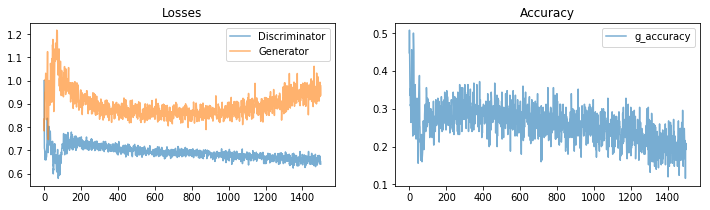

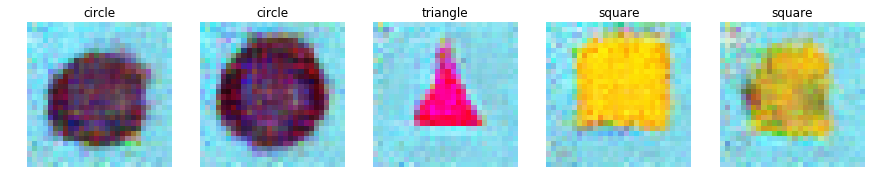

Epoch 300/500 
Duration: 1.19029 
D Loss: 0.65721 
G Loss: 0.97106


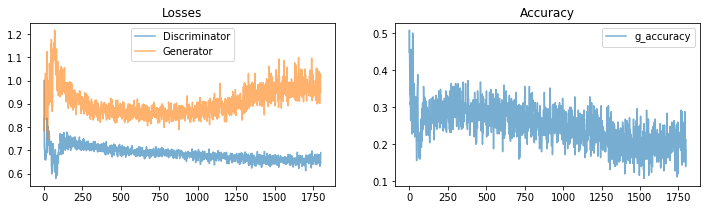

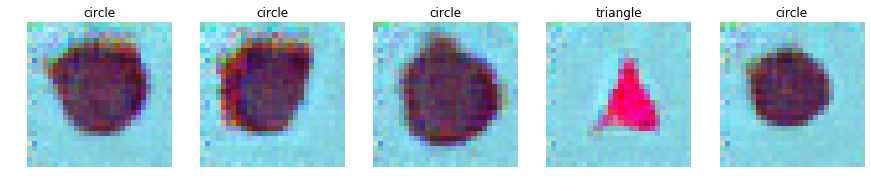

Epoch 350/500 
Duration: 1.18946 
D Loss: 0.68321 
G Loss: 0.91062


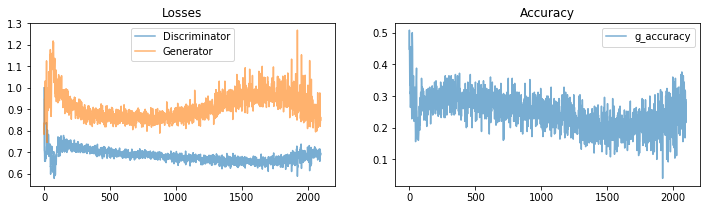

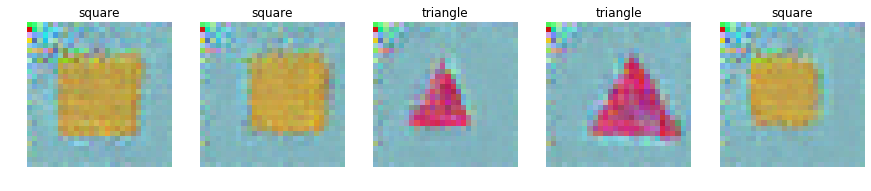

Epoch 400/500 
Duration: 1.19289 
D Loss: 0.68110 
G Loss: 0.86362


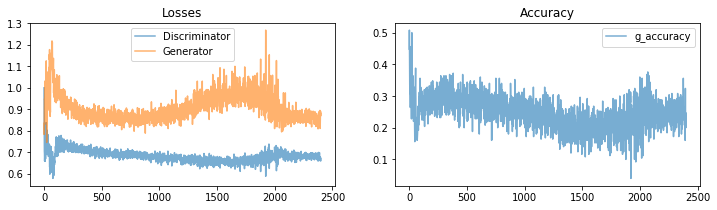

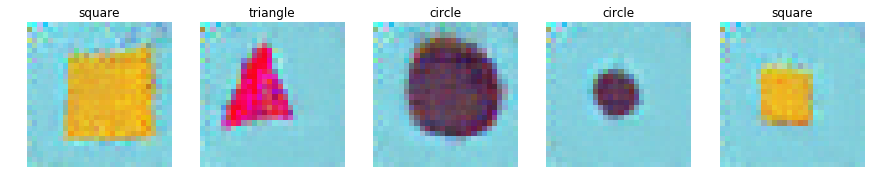

Epoch 450/500 
Duration: 1.18775 
D Loss: 0.67674 
G Loss: 0.86045


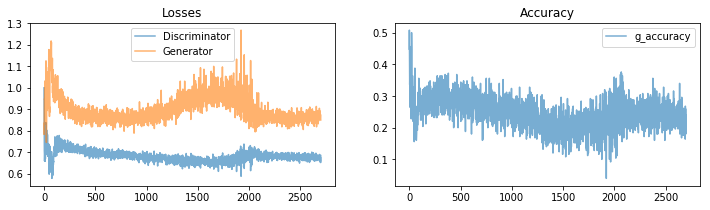

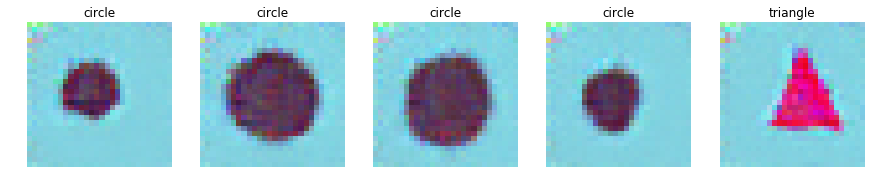

Epoch 500/500 
Duration: 1.19384 
D Loss: 0.66997 
G Loss: 0.87899


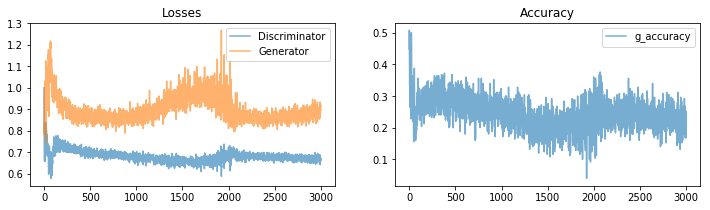

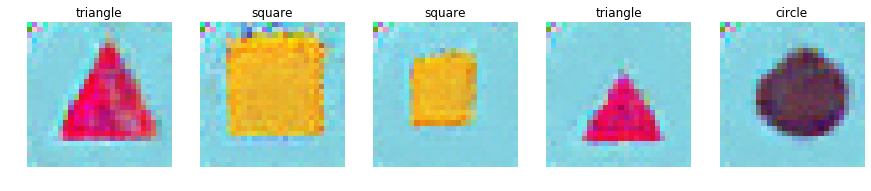

In [12]:
train_with_labels(get_batches(images, to_categorical(labels, num_classes=NUM_CLASSES)), generator_labels, discriminator_labels, gan_labels)

## 7) Results
Now we have a trained generator that can produce images with a specific label!

To test it out, we will produce an array of images for each of our classes.

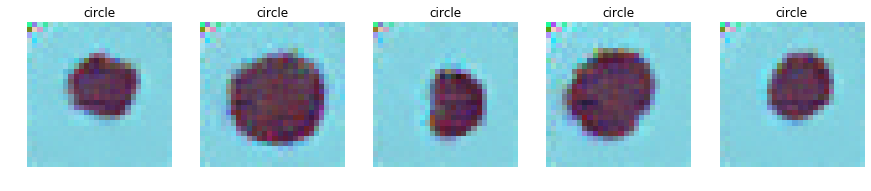

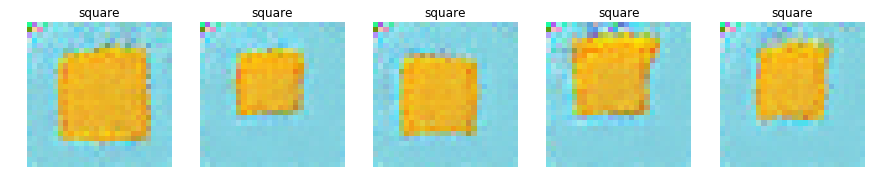

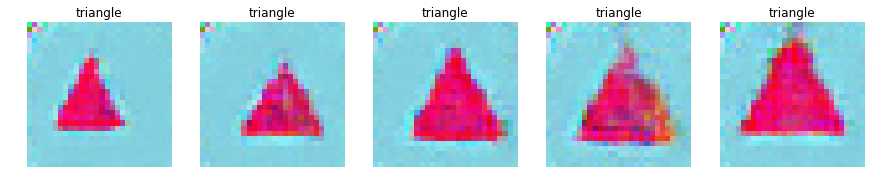

In [13]:
for i in range(NUM_CLASSES):
    sample_labels = np.ones(SAMPLES_TO_SHOW, dtype=int) * i
    sample_labels_encode = to_categorical(sample_labels, num_classes=NUM_CLASSES)
    noise = np.random.uniform(-1, 1, size=(SAMPLES_TO_SHOW, NOISE_SIZE))
    samples = generator_labels.predict([noise, sample_labels_encode])
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, [label_idx_map[k] for k in sample_labels])